## Gravity model and metrics

This jupyter notebook includes
 - implementation gravity model to predict human mobility flow based on the origin population, destination population, and distance between the origin and destination
 - metrics to evaluate the model fitness



In [10]:
import pandas as pd
import os
import numpy as np

os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd

from scipy.optimize import curve_fit

import seaborn as sns

from shapely.geometry import LineString

from keplergl import KeplerGl

### load human mobility flow data

In [11]:
%%time
file_path = os.path.join(os.getcwd(), 'data', 'od_table')
file_names = os.listdir(file_path)

data_frames = []
for file_name in file_names:
    if file_name.endswith(".csv"):
        df = pd.read_csv(os.path.join(file_path, file_name))
        df["date"] = file_name[3:11]
        data_frames.append(df)
        
flow = pd.concat(data_frames, ignore_index=True)
data_frames = None
print(flow.shape)

flow.head()

(544496, 4)
CPU times: user 123 ms, sys: 90.9 ms, total: 214 ms
Wall time: 5.35 s


,cell_o,cell_d,flow,date
0,0,3,2,20210708
1,0,11,1,20210708
2,0,37,1,20210708
3,0,64,1,20210708
4,0,155,1,20210708


In [12]:
flow_start = flow.groupby(['date', 'cell_o'])[['flow']].agg('sum').reset_index()
flow_start.rename(columns = {'flow': 'count_start'}, inplace=True)
print(flow_start.shape)
flow_start.head()

(8159, 3)


,date,cell_o,count_start
0,20210701,0,13
1,20210701,1,16
2,20210701,2,76
3,20210701,3,74
4,20210701,4,8


In [13]:
flow_end = flow.groupby(['date', 'cell_d'])[['flow']].agg('sum').reset_index()
flow_end.rename(columns = {'flow': 'count_end'}, inplace=True)
print(flow_end.shape)
flow_end.head()

(8162, 3)


,date,cell_d,count_end
0,20210701,0,13
1,20210701,1,20
2,20210701,2,62
3,20210701,3,72
4,20210701,4,9


In [14]:
print(flow.shape)
flow = pd.merge(left = flow, right = flow_start, on = ['date', 'cell_o'], how = 'inner')
print(flow.shape)
flow = pd.merge(left = flow, right = flow_end, on = ['date', 'cell_d'], how = 'inner')
print(flow.shape)
print(flow.isna().sum())
flow.head()

(544496, 4)
(544496, 5)
(544496, 6)
cell_o         0
cell_d         0
flow           0
date           0
count_start    0
count_end      0
dtype: int64


,cell_o,cell_d,flow,date,count_start,count_end
0,0,3,2,20210708,10,66
1,1,3,1,20210708,11,66
2,2,3,13,20210708,57,66
3,4,3,4,20210708,10,66
4,9,3,1,20210708,6,66


### load distance data

In [16]:
distance_wide = pd.read_csv(os.path.join(os.getcwd(), 'data', 'dist_matrix.csv'))
print(distance_wide.shape)
distance_wide.head()

(925, 925)


,0,1,2,3,4,5,6,7,8,9,...,915,916,917,918,919,920,921,922,923,924
0,0.000000,3.001186,6.002375,9.003569,12.004765,15.005963,18.007162,3.001183,4.244317,6.710860,...,102.216443,102.084273,102.040232,102.084435,102.216768,102.436888,102.744232,103.138022,103.617270,104.180797
1,3.001186,0.000000,3.001190,6.002383,9.003579,12.004777,15.005977,4.244317,3.001188,4.244323,...,102.436585,102.216616,102.084435,102.040383,102.084575,102.216896,102.437005,102.744339,103.138117,103.617354
2,6.002375,3.001190,0.000000,3.001193,6.002389,9.003587,12.004787,6.710860,4.244323,3.001192,...,102.743951,102.436748,102.216768,102.084575,102.040512,102.084692,102.217002,102.437100,102.744423,103.138189
3,9.003569,6.002383,3.001193,0.000000,3.001196,6.002394,9.003594,9.490595,6.710868,4.244328,...,103.137762,102.744103,102.436888,102.216896,102.084692,102.040617,102.084786,102.217085,102.437172,102.744483
4,12.004765,9.003579,6.002389,3.001196,0.000000,3.001198,6.002398,12.374228,9.490606,6.710875,...,103.617032,103.137903,102.744232,102.437005,102.217002,102.084786,102.040700,102.084858,102.217146,102.437222


In [17]:
distance_long = distance_wide.stack().reset_index()
distance_long.columns = ['cell_o', 'cell_d', 'spatial_distance']
distance_long['cell_o'] = distance_long['cell_o'].astype(int)
distance_long['cell_d'] = distance_long['cell_d'].astype(int)
distance_long.head()

,cell_o,cell_d,spatial_distance
0,0,0,0.000000
1,0,1,3.001186
2,0,2,6.002375
3,0,3,9.003569
4,0,4,12.004765


In [18]:
data = pd.merge(left = flow, right = distance_long, on = ['cell_o', 'cell_d'], how = 'inner')
print(flow.shape, data.shape)
data.rename(columns = {
    'cell_o': 'i', 
    'cell_d': 'j', 
    'count_start': 'pop_i', 
    'count_end': 'pop_j', 
    'spatial_distance': 'dist_ij', 
    'flow': 'true_traffic_flow'
}, inplace = True)
data.head()

(544496, 6) (544496, 7)


,i,j,true_traffic_flow,date,pop_i,pop_j,dist_ij
0,0,3,2,20210708,10,66,9.003569
1,0,3,2,20210701,13,72,9.003569
2,0,3,1,20210702,18,60,9.003569
3,0,3,4,20210703,22,40,9.003569
4,0,3,1,20210707,10,62,9.003569


### gravity model training

reference: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

In [40]:
test = data.query('date=="20210709"').copy()
train = data.query('date!="20210709"').copy()

test['observed_traffic_flow'] = test['true_traffic_flow']
train['observed_traffic_flow'] = train['true_traffic_flow']

print(test.shape)
print(train.shape)

(66349, 8)
(478147, 8)


In [41]:
# Gravity model equation
def gravity_model(dist, alpha, beta, gamma, K):
    return K * (dist['pop_i']**alpha) * (dist['pop_j']**beta) / (dist['dist_ij']**gamma)

# Fit the gravity model to the observed data
params, covariance = curve_fit(gravity_model, train[['pop_i', 'pop_j', 'dist_ij']], train['observed_traffic_flow'])

# Extract the optimized parameters
alpha_opt, beta_opt, gamma_opt, K_opt = params

# Calculate traffic flow using optimized parameters
train['predicted_traffic_flow'] = gravity_model(train[['pop_i', 'pop_j', 'dist_ij']], alpha_opt, beta_opt, gamma_opt, K_opt)
test['predicted_traffic_flow'] = gravity_model(test[['pop_i', 'pop_j', 'dist_ij']], alpha_opt, beta_opt, gamma_opt, K_opt)

# Print results
print("Optimized Parameters:")
print(f"alpha: {alpha_opt:.2f}, beta: {beta_opt:.2f}, gamma: {gamma_opt:.2f}, K: {K_opt:.2f}")
print("\nDataFrame with Results:")
test.head()

Optimized Parameters:
alpha: 0.62, beta: 0.62, gamma: 2.89, K: 0.53

DataFrame with Results:


,i,j,true_traffic_flow,date,pop_i,pop_j,dist_ij,observed_traffic_flow,predicted_traffic_flow
14,2,3,19,20210709,82,72,3.001193,19,4.785861
23,4,3,1,20210709,7,72,3.001196,1,1.039642
31,9,3,1,20210709,7,72,4.244328,1,0.382228
33,11,3,1,20210709,2,72,4.244332,1,0.175695
39,36,3,1,20210709,29,72,6.710872,1,0.245958


<Axes: xlabel='observed_traffic_flow', ylabel='predicted_traffic_flow'>

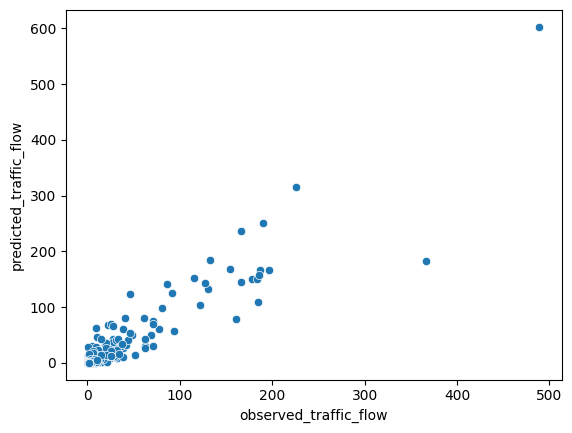

In [21]:
sns.scatterplot(train[['observed_traffic_flow', 'predicted_traffic_flow']].sample(1000), 
                x="observed_traffic_flow", y='predicted_traffic_flow')

### gravity model evaluation

references: https://www.nature.com/articles/s41467-021-26752-4

common metric used to evaluate the performance of flow generation models: 
- Sørensen-Dice index, also called Common Part of Commuters (CPC): similarity between real flows, and generated flows
- Pearson correlation coefficient: correlation
- Normalized Root Mean Squared Error (NRMSE): error
- Jensen-Shannon divergence (JSD): dissimilarity 

In [22]:
# statistics and machine laerning 
from sklearn.metrics import mean_squared_error
from scipy.spatial import distance
from scipy.stats.mstats import spearmanr, pearsonr


def dice_coefficient(a, b):
    """Computes the Sørensen–Dice coefficient of two arrays a and b."""
    intersection = np.sum(np.minimum(a, b))
    return (2.0 * intersection) / (np.sum(a) + np.sum(b))

def compare_flow(truth_data, pred_data):
    pearsonr_c, pearsonr_p = pearsonr(truth_data, pred_data)
    spearmanr_c, spearmanr_p = spearmanr(truth_data, pred_data)
    rmsr = np.sqrt(mean_squared_error(truth_data, pred_data)) #/ (max(diff) - min(diff))
    jsd = distance.jensenshannon(truth_data, pred_data) ** 2
    dice = dice_coefficient(truth_data, pred_data)
    
    return([pearsonr_c, pearsonr_p, spearmanr_c, spearmanr_p, rmsr, jsd, dice])

In [23]:
%%time
truth_data = test['observed_traffic_flow'].tolist()
pred_data = test['predicted_traffic_flow'].tolist()
diff = (test['observed_traffic_flow'] - test['predicted_traffic_flow']).tolist()

compare_flow_re = compare_flow(truth_data, pred_data)
print(compare_flow_re)

[0.916879106460991, 0.0, 0.6887994047784377, 0.0, 12.20600593736994, 0.06326906033616007, 0.7414067272464896]
CPU times: user 300 ms, sys: 12.1 ms, total: 312 ms
Wall time: 317 ms


In [24]:
%%time
truth_data = train['observed_traffic_flow'].tolist()
pred_data = train['predicted_traffic_flow'].tolist()
diff = (train['observed_traffic_flow'] - train['predicted_traffic_flow']).tolist()

compare_flow_re = compare_flow(truth_data, pred_data)
print(compare_flow_re)

[0.9153339924305575, 0.0, 0.6815762127649561, 0.0, 10.70589483057684, 0.06402183252701896, 0.7362882322553218]
CPU times: user 2.08 s, sys: 68.7 ms, total: 2.15 s
Wall time: 2.16 s


In [42]:
# 0.7284138883872593, 0.0, 0.6685821060599887, 0.0, 86.95607286924562, 0.13661746806466118, 0.5548179566314907]
# [pearsonr_c, pearsonr_p, spearmanr_c, spearmanr_p, rmsr, jsd, dice]

### deep learning model evaluation

In [54]:
print(test.shape)

(66349, 10)


In [57]:
dl_re_wea = pd.read_csv(os.path.join(os.getcwd(), 'results', 'with_weather_test.csv'))
dl_re_nowea = pd.read_csv(os.path.join(os.getcwd(), 'results', 'without_weather_test.csv'))
print(dl_re_wea.shape)
print(dl_re_nowea.shape)

dl_re_wea = dl_re_wea.groupby(['o', 'd']).agg('mean').reset_index()
dl_re_nowea = dl_re_nowea.groupby(['o', 'd']).agg('mean').reset_index()
print(dl_re_wea.shape)
print(dl_re_nowea.shape)

dl_re_wea.head(1)

(391464, 4)
(391464, 4)
(53445, 4)
(53445, 4)


,o,d,Predict_flow,Actual_flow
0,2.0,0.0,0.376997,0.0


In [72]:
dl_re = pd.merge(
    left = dl_re_wea,
    right = dl_re_nowea, 
    on = ['o', 'd'], 
    how = 'inner', 
    suffixes = ('_wea', '_nowea')
)
print(dl_re.shape)

dl_re['o'] = dl_re['o'].astype(int)
dl_re['d'] = dl_re['d'].astype(int)
dl_re.head()

(53445, 6)


,o,d,Predict_flow_wea,Actual_flow_wea,Predict_flow_nowea,Actual_flow_nowea
0,2,0,0.376997,0.0,0.951154,0.0
1,2,1,2.733390,4.0,5.410487,4.0
2,2,3,18.937828,19.0,9.469562,19.0
3,2,4,0.471508,1.0,0.999822,1.0
4,2,5,0.307353,0.0,0.558237,0.0


In [61]:
grid_shp.dtypes

geometry    geometry
cell_id        int64
dtype: object

In [58]:
%%time
truth_data = dl_re_wea['Actual_flow'].tolist()
pred_data = dl_re_wea['Predict_flow'].tolist()
diff = (dl_re_wea['Actual_flow'] - dl_re_wea['Predict_flow']).tolist()

compare_flow_re = compare_flow(truth_data, pred_data)
print(compare_flow_re)

[0.946314196968256, 0.0, 0.7733098315209774, 0.0, 12.438559443692501, 0.0663798035879846, 0.7545328582691408]
CPU times: user 235 ms, sys: 40.4 ms, total: 275 ms
Wall time: 498 ms


In [59]:
%%time
truth_data = dl_re_nowea['Actual_flow'].tolist()
pred_data = dl_re_nowea['Predict_flow'].tolist()
diff = (dl_re_nowea['Actual_flow'] - dl_re_nowea['Predict_flow']).tolist()

compare_flow_re = compare_flow(truth_data, pred_data)
print(compare_flow_re)

[0.9327891413009042, 0.0, 0.7545665576328584, 0.0, 13.109700782558948, 0.07461404582624394, 0.7388528848046916]
CPU times: user 242 ms, sys: 20.5 ms, total: 263 ms
Wall time: 291 ms


### visualization

In [34]:
grid_shp = gpd.read_file(os.path.join(os.getcwd(), 'data', 'fishnet_3km.json'))
print(grid_shp.shape)

grid_shp['geometry'] = grid_shp['geometry'].centroid
grid_shp.to_crs('epsg:4326', inplace=True)

grid_shp['cell_id'] = grid_shp.index
print(grid_shp.crs)
grid_shp.head()

(925, 1)
epsg:4326


,geometry,cell_id
0,POINT (-93.27079 44.48441),0
1,POINT (-93.23306 44.48449),1
2,POINT (-93.19534 44.48456),2
3,POINT (-93.15761 44.48462),3
4,POINT (-93.11988 44.48467),4


In [39]:
gdf_start.head()

,i,j,true_traffic_flow,date,pop_i,pop_j,dist_ij,observed_traffic_flow,predicted_traffic_flow,geometry_x,geometry_y,cell_id
0,2,3,19,20210709,82,72,3.001193,19,4.785861,LINESTRING (-93.19533650247398 44.484563312278...,POINT (-93.19534 44.48456),2
1,4,3,1,20210709,7,72,3.001196,1,1.039642,LINESTRING (-93.11988289834156 44.484667216982...,POINT (-93.11988 44.48467),4
2,9,3,1,20210709,7,72,4.244328,1,0.382228,LINESTRING (-93.19542663351649 44.511571213775...,POINT (-93.19543 44.51157),9
3,11,3,1,20210709,2,72,4.244332,1,0.175695,LINESTRING (-93.11993821810954 44.511675247756...,POINT (-93.11994 44.51168),11
4,36,3,1,20210709,29,72,6.710872,1,0.245958,LINESTRING (-93.19551680866779 44.538579003082...,POINT (-93.19552 44.53858),36


In [73]:
%%time
print(dl_re.shape)
gdf_start = pd.merge(
    left = dl_re, 
    right = grid_shp, 
    how = 'left', 
    left_on = 'o', 
    right_on = 'cell_id'
)
print(gdf_start.shape)

gdf_end = pd.merge(
    left = dl_re, 
    right = grid_shp, 
    how = 'left', 
    left_on = 'd', 
    right_on = 'cell_id'
)
print(gdf_end.shape)

dl_re['geometry'] = [LineString([start, end]) for start, end in zip(gdf_start['geometry'], gdf_end['geometry'])]
flow_gdf = gpd.GeoDataFrame(dl_re, geometry=dl_re['geometry'], crs="EPSG:4326")
print(flow_gdf.shape)
flow_gdf.head()

(53445, 6)
(53445, 8)
(53445, 8)
(53445, 7)
CPU times: user 653 ms, sys: 13.7 ms, total: 666 ms
Wall time: 675 ms


,o,d,Predict_flow_wea,Actual_flow_wea,Predict_flow_nowea,Actual_flow_nowea,geometry
0,2,0,0.376997,0.0,0.951154,0.0,"LINESTRING (-93.19534 44.48456, -93.27079 44.4..."
1,2,1,2.733390,4.0,5.410487,4.0,"LINESTRING (-93.19534 44.48456, -93.23306 44.4..."
2,2,3,18.937828,19.0,9.469562,19.0,"LINESTRING (-93.19534 44.48456, -93.15761 44.4..."
3,2,4,0.471508,1.0,0.999822,1.0,"LINESTRING (-93.19534 44.48456, -93.11988 44.4..."
4,2,5,0.307353,0.0,0.558237,0.0,"LINESTRING (-93.19534 44.48456, -93.08216 44.4..."


In [42]:
%%time
gdf_start = pd.merge(
    left = test, 
    right = grid_shp, 
    how = 'left', 
    left_on = 'i', 
    right_on = 'cell_id'
)
print(gdf_start.shape)

gdf_end = pd.merge(
    left = test, 
    right = grid_shp, 
    how = 'left', 
    left_on = 'j', 
    right_on = 'cell_id'
)
print(gdf_end.shape)

test['geometry'] = [LineString([start, end]) for start, end in zip(gdf_start['geometry'], gdf_end['geometry'])]
flow_gdf = gpd.GeoDataFrame(test, geometry=test['geometry'], crs="EPSG:4326")
print(flow_gdf.shape)
flow_gdf.head()

(66349, 11)
(66349, 11)
(66349, 10)
CPU times: user 810 ms, sys: 18.2 ms, total: 828 ms
Wall time: 860 ms


,i,j,true_traffic_flow,date,pop_i,pop_j,dist_ij,observed_traffic_flow,predicted_traffic_flow,geometry
14,2,3,19,20210709,82,72,3.001193,19,4.785861,"LINESTRING (-93.19534 44.48456, -93.15761 44.4..."
23,4,3,1,20210709,7,72,3.001196,1,1.039642,"LINESTRING (-93.11988 44.48467, -93.15761 44.4..."
31,9,3,1,20210709,7,72,4.244328,1,0.382228,"LINESTRING (-93.19543 44.51157, -93.15761 44.4..."
33,11,3,1,20210709,2,72,4.244332,1,0.175695,"LINESTRING (-93.11994 44.51168, -93.15761 44.4..."
39,36,3,1,20210709,29,72,6.710872,1,0.245958,"LINESTRING (-93.19552 44.53858, -93.15761 44.4..."


In [43]:
%%time
flow_gdf.to_file(os.path.join(os.getcwd(), 'results', 'shp', 'flow_gdf.shp'))

<timed eval>:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.


CPU times: user 1.84 s, sys: 195 ms, total: 2.04 s
Wall time: 2.16 s


In [75]:
%%time
# flow_gdf = gpd.read_file(os.path.join(os.getcwd(), 'results', 'shp', 'flow_gdf.shp'))
flow_gdf.head()

CPU times: user 2.4 ms, sys: 2.38 ms, total: 4.78 ms
Wall time: 5.1 ms


,o,d,Predict_flow_wea,Actual_flow_wea,Predict_flow_nowea,Actual_flow_nowea,geometry
0,2,0,0.376997,0.0,0.951154,0.0,"LINESTRING (-93.19534 44.48456, -93.27079 44.4..."
1,2,1,2.733390,4.0,5.410487,4.0,"LINESTRING (-93.19534 44.48456, -93.23306 44.4..."
2,2,3,18.937828,19.0,9.469562,19.0,"LINESTRING (-93.19534 44.48456, -93.15761 44.4..."
3,2,4,0.471508,1.0,0.999822,1.0,"LINESTRING (-93.19534 44.48456, -93.11988 44.4..."
4,2,5,0.307353,0.0,0.558237,0.0,"LINESTRING (-93.19534 44.48456, -93.08216 44.4..."


In [86]:
%%time
map_compare = KeplerGl(height=600, config = {
    'version': 'v1',
    'config': {
        'mapState': {
            'latitude': 44.9375,
            'longitude': -93.2010,
            'zoom': 7.5
        }
    }
})

map_compare.add_data(data=flow_gdf.query('Actual_flow_wea>1'), name='wea')
map_compare.add_data(data=flow_gdf.query('Actual_flow_wea>1'), name='nowea')

map_compare.config = {
    'version': 'v1',
    'config': {
        'mapState': {
            'latitude': 44.9375,
            'longitude': -93.2010,
            'zoom': 7.5
        }
    }
}

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
CPU times: user 384 ms, sys: 39.4 ms, total: 423 ms
Wall time: 438 ms


In [74]:
%%time
map_compare = KeplerGl(height=600, config = {
    'version': 'v1',
    'config': {
        'mapState': {
            'latitude': 44.9375,
            'longitude': -93.2010,
            'zoom': 7.5
        }
    }
})

map_compare.add_data(data=flow_gdf.query('observed_t>1'), name='observe')
map_compare.add_data(data=flow_gdf.query('observed_t>1'), name='predict')

map_compare.config = {
    'version': 'v1',
    'config': {
        'mapState': {
            'latitude': 44.9375,
            'longitude': -93.2010,
            'zoom': 7.5
        }
    }
}

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


UndefinedVariableError: name 'observed_t' is not defined

In [87]:
map_compare

KeplerGl(config={'version': 'v1', 'config': {'mapState': {'latitude': 44.9375, 'longitude': -93.201, 'zoom': 7…